In [1]:
import logging
from typing import Any
from pdb import set_trace
from importlib import reload

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.signal import savgol_filter

from gfatpy.config import set_logger_level
from gfatpy.lidar.preprocessing import preprocess
from gfatpy.lidar import utils
from gfatpy.atmo import ecmwf, atmo
from gfatpy.lidar.retrieval import klett
from gfatpy.lidar.retrieval.helper import RetrievalHelper

set_logger_level("WARNING")

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Read data

In [2]:
RS_FL = r"../tests/datos/MULHACEN/1a/2022/08/08/*Prs*.nc"
DC_FL = r"../tests/datos/MULHACEN/1a/2022/08/08/*Pdc*.nc"

lidar = preprocess(
    rs_fl=RS_FL,
    dc_fl=DC_FL,
    channels=["532xpa"],
    deadtime_flag=False,
)

TypeError: preprocess() got an unexpected keyword argument 'rs_fl'

In [ ]:
n_profile = 30
prof = lidar.signal_532xpa[n_profile, :].values
rcs = prof * lidar["range"] ** 2

In [ ]:
plt.plot(rcs, np.arange(len(rcs.values))*7.5)

plt.show()

### Create a synthetic profile

In [ ]:
z = lidar["range"].values

P, params = utils.generate_synthetic_signal(z, wavelength=532, force_zero_aer_after_bin=1100, k_lidar = 2e11)

In [ ]:
print(params.keys())

In [ ]:
plt.plot(params["particle_beta"], z)
plt.plot(params["molecular_beta"], z)

plt.ylim((0, 7500))

In [ ]:
plt.plot(params["particle_accum_ext"], z)
plt.plot(params["molecular_accum_ext"], z)

plt.plot(params["transmittance"], z)


plt.ylim((0, 7500))

In [ ]:
plt.plot(P * z**2, z)

plt.ylim((0, 7500))

In [ ]:
klett.klett_rcs(P * z**2, range_profile = z, beta_mol_profile=params["molecular_beta"])

NameError: name 'params' is not defined

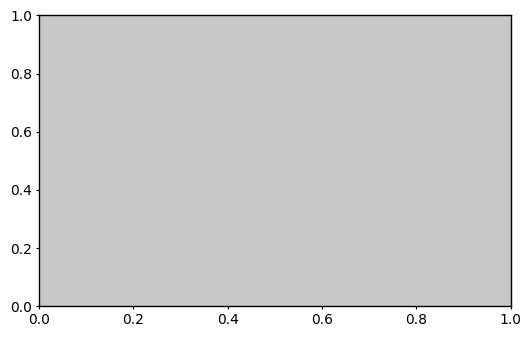

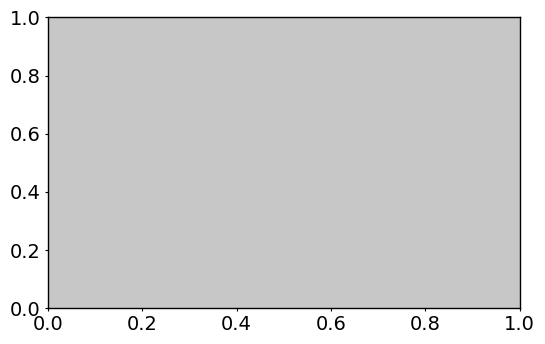

In [3]:
fig, ax = plt.subplots()

ax.plot(params['molecular_beta'], z, label = "molecular beta")
ax.plot(params['particle_beta'], z, label = "particle beta")


ax.legend()

### Rayleigh fit

In [ ]:
fig, ax = plt.subplots()

beta_total = params["molecular_beta_att"]

P_rcs = P * z**2
beta_att_norm = beta_total / beta_total[np.searchsorted(z, 7500)]
p_norm = P_rcs / P_rcs[np.searchsorted(z, 7500)]

ax.plot(z, beta_att_norm, alpha = 0.7, label = "Molecular attenuated betta")
ax.plot(z, p_norm, alpha = 0.7, label = "Synthetic lidar RCS")


ax.set(ylabel="Normalized signal [a.u]",xlabel="Range [m]")
ax.set_yscale("log")

ax.legend()


### Std profile

In [ ]:
std_profiles = (400, 415)

rs = lidar.signal_532xpa[std_profiles[0]:std_profiles[1]]

mean = rs.mean(axis = 0).values
std = rs.std(axis = 0).values

fig, ax = plt.subplots()

ax.plot(mean, z, '--',alpha = 0.5 , lw=0.8, label="Mean $P(R)$")

ax2 = ax.twiny()
ax2.plot(std, z, lw=0.8 ,alpha = 0.5, c = 'k', label = "Std deviation")

ax2.set(xlabel=f"Std from profiles {50, 200} [mV]")
ax2.legend(loc=9)

ax.set(xlabel="Mean output signal [mV]",ylabel="Range [m]")
ax.legend()

plt.show()

### Montecarlo profiles

In [ ]:
def generate_noisy_profiles(mean: np.ndarray, std: np.ndarray, n_profiles: int = 30) -> np.ndarray:
    profiles: Any = None
    for n in range(n_profiles):
        if profiles is None:
            profiles = np.random.normal(mean, std)
        else:
            profiles = np.vstack([profiles, np.random.normal(mean, std)])
    
    return profiles

noise_profiles = generate_noisy_profiles(P, std, n_profiles = 30)

In [ ]:
fig, ax = plt.subplots()

bin_limit = 0

for i in noise_profiles:
    ax.plot(i[bin_limit:] * z[bin_limit:]**2, z[bin_limit:], c = "k", lw = 0.1)

ax.plot(P*z**2, z, c = 'r')

### Klett inversion

In [ ]:
klett_res = klett.klett_rcs(P_rcs, range_profile = z, beta_mol_profile=params["molecular_beta"])
klett_noise = klett.klett_rcs(noise_profiles[0: 15].mean(axis=0) *z**2, range_profile = z, beta_mol_profile=params["molecular_beta"])
klett_noise2 = klett.klett_rcs(noise_profiles[0: 15].mean(axis=0) *z**2, range_profile = z, beta_mol_profile=params["molecular_beta"], ymin=6000, ymax=8000)

In [ ]:
fig, ax = plt.subplots()

ax.plot(params["particle_beta"], z, label = r"$\beta_{part}$", alpha = 0.7)
ax.plot(klett_res, z, '--', label = r"$\beta_{part}$ Klett", alpha = 0.7)
ax.plot(klett_noise, z, label = r"$\beta_{part}$ Klett noise avg15", alpha = 0.7)
ax.plot(klett_noise2, z, label = r"$\beta_{part}$ Klett noise 6-7", alpha = 0.7)
# ax.plot(savgol_filter(klett_noise, 15, 3), z, label = r"$\beta_{part}$ Klett noise filter avg15", alpha = 0.7)

ax.set(ylabel="Normalized signal [a.u]",xlabel="Range [m]")

plt.xlim((0, 4e-6))
plt.ylim((0, 1e4))

ax.legend()

In [ ]:
k_lidar = P_rcs / (klett_noise2 + params["molecular_beta"]) / params["transmittance"]**2

In [ ]:
plt.plot(k_lidar, z)

plt.xlim((0, 4e11))
plt.ylim((0, 10000))

In [ ]:
1500 / 7.5

In [ ]:
k_lidar_mean = k_lidar[200:400].mean()
k_lidar[200:400].std()

In [ ]:
print(f"{k_lidar_mean:.2e}")
print(f"{k_lidar[200:400].std():.2e}")

In [ ]:
params.keys()


### Retrieval helper

In [ ]:
from datetime import datetime

rh = RetrievalHelper(lidar)

In [ ]:
rh.data

In [ ]:
rh.rcs

In [ ]:
rh.quicklook()

In [ ]:
rh.data['signal_532xpa'].sel(range=slice(4000,5000), time=slice("20220808T120000.0","20220808T123000.0")).mean('time')

In [ ]:
# Como hacer queries dentro de xarray
# rh.data.sel(time=slice(), range=slice()).values

### Klett on profile

In [ ]:
ecmwf_13 = ecmwf.get_ecmwf_temperature_pressure("2022-08-08", hour = 13, ranges_array = z)
params_atmo = atmo.molecular_properties(rh.wavelength, ecmwf_13.pressure, ecmwf_13.temperature, z)


In [ ]:
params = atmo.molecular_properties(rh.wavelength, ecmwf_13.pressure, ecmwf_13.temperature, z)

rh.plot_profile(400)
rh.plot_profile(500)

rh.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(rh.klett_on_profile(400), z, label = r"$\beta_{part}$ Klett [$sr^{-1}m^{-1}$]")

ax.legend()

### Windowed Klett

In [ ]:
# Window Klett with 30 profiles (which equals 30 minutes in this case)

In [ ]:
std = rh.rcs[400:430].std(axis=0)
mean = rh.rcs[400:430].mean(axis=0)

In [ ]:
for i in rh.rcs[400:430]:
    plt.plot(i, z)

plt.plot(mean, z, c='k')
plt.plot(mean - std, z, c='w')
plt.plot(mean + std, z, c='w')

    

plt.xlim((0, 4e6))
plt.ylim((0, 1e4))

In [ ]:
plt.plot(std, z, label = "30 min standard deviation")
plt.xlabel("Range corrected signal units [a.u]")
plt.ylabel("Range [m]")

plt.show()

In [ ]:
N_SAMPLES = 30

profiles = None
kletts = None

for i in range(N_SAMPLES):
    if profiles is None:
        profiles = np.random.normal(mean, std)
    else:
        profiles = np.vstack([profiles, np.random.normal(mean, std)])

for profile in profiles:
    if kletts is None:
        kletts = klett.klett_rcs(profile, range_profile = z, beta_mol_profile=params["molecular_beta"])
    else:
        kletts = np.vstack([kletts, klett.klett_rcs(profile, range_profile = z, beta_mol_profile=params["molecular_beta"])])

kletts_std = kletts.std(axis = 0)
kletts_mean = kletts.mean(axis = 0)

In [ ]:
for i in profiles:
    plt.plot(i, z)

plt.plot(mean, z, c='k')
plt.plot(mean - std, z, c='w')
plt.plot(mean + std, z, c='w')
plt.plot(profiles.mean(axis = 0) - profiles.std(axis=0), z)
plt.plot(profiles.mean(axis = 0) + profiles.std(axis=0), z)

plt.xlim((0, 4e6))
plt.ylim((0, 1e4))

In [ ]:
plt.plot(rh.rcs[0], z)
plt.plot(profiles[0], z)
plt.plot(rh.rcs[-1], z)

plt.xlim((0, 4e6))
plt.ylim((0, 1e4))

In [ ]:
profiles.std(axis=0)

In [ ]:
# 10.2 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# Times, ms, ms
# Results obtaining with %%timeit to previous cell

times = np.array([
    [20, 6.43, 0.145],
    [30, 10.4, 0.170],
    [40, 14.6, 0.332],
    [50, 18.1, 0.271],
    [60, 24.2, 1.04], # 10 runs
    [70, 32.6, 1.81],
    [80, 41.2, 2.89],
    [110, 70.1, 2.38],
    [150, 118, 5.2],
    [200, 200, 14.3],
    [300, 410, 29.7]
])

In [ ]:
# plt.plot(times[:, 0], times[:, 1], c = 'b')
plt.title("Time to compute Klett inversion N profiles")
plt.errorbar(times[:, 0], times[:, 1], times[:, 2], capsize=2)

plt.xlabel('N profiles')
plt.ylabel('Time [ms]')

plt.show()

In [ ]:
times[:, 0]

In [ ]:
klett_mean = klett.klett_rcs(mean, range_profile = z, beta_mol_profile=params["molecular_beta"])

plt.plot(klett_mean, z, label = "30 min klett standard deviation",  lw = 0.2)
plt.fill_betweenx(z, klett_mean+kletts_std, klett_mean-kletts_std, alpha = 0.3)

plt.xlabel("Range corrected signal units [a.u]")
plt.ylabel("Range [m]")

plt.xlim((0, 4e-6))
plt.ylim((0, 1e4))

plt.show()

In [ ]:
RH

### Profile analysis

In [ ]:
klett.klett_likely_bins(rh.rcs[400], params["attenuated_molecular_beta"], z)

In [ ]:
rh.data.time[400]

In [ ]:
plt.plot(rh.rcs[400], z)

In [ ]:
2.5-1.8